In [1]:
import numpy as np
# библиотека для вывода на консоль массивов
import matplotlib.pyplot
# убедитесь, что участки находятся внутри этой записной книжки, а не внешнего окна
%matplotlib inline
#plt.show() # Вместо %matplotlib inline в других средах, не notebook
from time import time, sleep #Для замера времени выполнения функций
from tqdm import tqdm #Для вывода прогресса вычисления функций
# glob помогает выбрать несколько файлов, используя шаблоны
import glob
# помощник для загрузки данных из файлов изображений PNG
import scipy.misc
import re # Для извлечения дробной и целой части

In [2]:
# Загрузить mnist тренировочные данные в формате CSV 
training_data_file = open("MNIST_dataset/mnist_train_100.csv", 'r') # 'r' - открываем файл для чтения
training_data_list = training_data_file.readlines() # readlines() - читает все строки в файле в переменную training_data_list
training_data_file.close() # закрываем фаел csv

In [3]:
# Определение класса нейронной сети
class neuron_Net:
        
    # инициализация нейронной сети
    def __init__(self, input_num, hidden_num, maxpul_num, output_num, learningrate): #констр.(входной слой, скрытый слой, макспул, выходной слой)
       
        self.m = 28 #Размер входного массива(ДхШ)
        self.k = 5 #Размер весов (ДхШ)
        self.m_k_1 = (self.m-self.k)+1
        self.stok_w = 9 #Число ядер свертки (весов)
        self.stob_w = self.k*self.k #Количество элементов 1го ядра свертки
        self.x1 = np.zeros((self.stok_w, self.m_k_1, self.m_k_1)) #Массив скрытого слоя
        
        # Пулиинг данные
        self.pool_m = 2 # Матрица ядра пуллинга
        self.m_k_1_pool = int(self.m_k_1/self.pool_m) # Размерность слоя пуллинга
        self.hidden_outputs_mp = np.zeros((self.stok_w, self.m_k_1_pool, self.m_k_1_pool)) # Массива пулинга
        self.hidden_outputs_el = np.zeros((self.stok_w, self.m_k_1_pool, self.m_k_1_pool), dtype='<U32') # хранит адрес макс. элемента
        
        #Для вывода карт свойст скрытого слоя  
        self.hidden_outputs_image = np.zeros((self.stok_w, self.m_k_1, self.m_k_1))
                                                    # МАТРИЦЫ ВЕСОВ
        self.weights = np.random.normal(0.0, pow(self.stob_w, -0.5), (self.stok_w, self.k, self.k)) 
        self.weights_out = np.random.normal(0.0, pow(maxpul_num, -0.5), (output_num, maxpul_num)) # После пуллинг слоя

        # скорость обучения
        self.lr = learningrate
        
        # функция активации-функция сигмоида
        self.activation_function = lambda x: scipy.special.expit(x)
        
        pass

    
    # обучение нейронной сети
    def train(self, inputs_list, targets_list): # принемает входной список данных,targets ответы
        # Преобразовать список входов в 2D массив
        inputs_x = np.array(inputs_list.reshape(self.m , self.m)) # матрица числа

        targets_Y = np.array(targets_list, ndmin=2).T # матрица ответов какое это число
        
        
                                        # ВЫЧИСЛЕНИЕ СИГНАЛОВ ПО СЛОЯМ
        # вычислить сигналы в скрытом слое (матрица сигналов скрытого слоя)        
        for s in range(self.stok_w):
            for h in range(self.m_k_1):
                for w in range(self.m_k_1):
                    self.x1[s,h,w] = np.sum(inputs_x[h:h+self.k, w:w+self.k] * self.weights[s])
        
        # вычислить сигналы, возникающие из скрытого слоя.
        y1 = self.activation_function(self.x1) #Сигмоида
        
        # Макспуллинг
        for s in range(self.stok_w):
            for h in range(self.m_k_1_pool):
                for w in range(self.m_k_1_pool):
                    temp2 = y1[s, h*self.pool_m:h*self.pool_m+self.pool_m, w*self.pool_m:w*self.pool_m+self.pool_m] # Для хранения подматрицы с нулевыми и макс знач.
                    self.hidden_outputs_mp[s,h,w] = y1[s, h*self.pool_m:h*self.pool_m+self.pool_m, w*self.pool_m:w*self.pool_m+self.pool_m].max() # Матрица массива пулинга
                    for i in range(self.pool_m):
                        for j in range(self.pool_m):
                            if temp2[i, j] == self.hidden_outputs_mp[s,h,w]:
                                temp3 = str(i+h*self.pool_m) + ',' + str(j+w*self.pool_m)
                        
                    self.hidden_outputs_el[s, h, w] = temp3
        
        
        # вычислить сигналы в окончательный выходной слой (матрица сигналов выходного слоя)
        x2 = np.dot(self.weights_out, np.array(self.hidden_outputs_mp.flatten(), ndmin=2).T) # сигнал вых.слоя = вес скр. слоя * значение сигнала скр.слоя
        # вычислить сигналы, исходящие из конечного выходного слоя
        y2 = self.activation_function(x2) # Сигмоида
        
                                            # ВЫЧИСЛЕНИЕ ОШИБКИ ПО СЛОЯМ
        #  ошибка выходного слоя является (цель - фактическое) 
        E = -(targets_Y - y2)
        # Скрытая ошибка слоя макспулинга
        hidden_errors_mp = np.dot(self.weights_out.T, E) # Одномерный, вертикальный
        hidden_errors_mp = self.hidden_outputs_mp.reshape(self.stok_w, self.m_k_1_pool, self.m_k_1_pool)# 3D
        
        # Обнулим ошибки перед пулингом
        E_hidden = np.zeros((self.stok_w, self.m_k_1, self.m_k_1))
        for s in range(self.stok_w):
            for h in range(self.m_k_1_pool):
                for w in range(self.m_k_1_pool):
                    result = re.split(r'[,]', self.hidden_outputs_el[s,h,w]) # Разбивает строку по разделителю ',' можно сраху несколько разделителей 
                    i = int(result[0])
                    j = int(result[1])
                    E_hidden[s,i,j] = hidden_errors_mp[s,h,w]
        
        
                                            # ОБНОВЛЕНИЕ ВЕСОВ ПО СЛОЯМ
        # обновления весов связей между скрытым пуллинг слоем и выходным слоями
        self.weights_out -= self.lr * np.dot((E * y2 
                                          * (1.0 - y2)), np.transpose(np.array(self.hidden_outputs_mp.flatten(), ndmin=2).T)) # Сигмоида        
        
        # обновления весов связей между входным и скрытым слоями             
        for s in range(self.stok_w):
            for h in range(self.k):
                for w in range(self.k):
                    inputs_t = inputs_x[h:h+self.m_k_1, w:w+self.m_k_1]
                    inputs_t = np.fliplr(inputs_t)
                    inputs_t = np.flipud(inputs_t)
                    self.weights[s, h, w] -= np.sum(E_hidden[s] * inputs_t * self.lr) #Для софтмакс и без функции активации и RRELU на выходе
                    
        #Запоминаем карту свойст скрытого слоя перед пулингом для просмотра            
        self.hidden_outputs_image = y1 
        pass

                                        # МЕТОД ПРОГОНА СВОИХ ЗНАЧЕНИЙ ПО СЕТИ
    # запросить нейронную сеть
    def query(self, inputs_list): # Функция прогонки по слоям своих данных. Принемает свой набор тестовых данных
        # Преобразовать список входов в 2D массив
        inputs_x = np.array(inputs_list.reshape(self.m , self.m)) # матрица числа
        
        # вычислить сигналы в скрытом слое (матрица сигналов скрытого слоя)        
        for s in range(self.stok_w):
            for h in range(self.m_k_1):
                for w in range(self.m_k_1):
                    self.x1[s,h,w] = np.sum(inputs_x[h:h+self.k, w:w+self.k] * self.weights[s])
        
        # вычислить сигналы, возникающие из скрытого слоя.
        y1 = self.activation_function(self.x1) #Сигмоида
        
        # Макспуллинг
        for s in range(self.stok_w):
            for h in range(self.m_k_1_pool):
                for w in range(self.m_k_1_pool):
                    temp2 = y1[s, h*self.pool_m:h*self.pool_m+self.pool_m, w*self.pool_m:w*self.pool_m+self.pool_m] # Для хранения подматрицы с нулевыми и макс знач.
                    self.hidden_outputs_mp[s,h,w] = y1[s, h*self.pool_m:h*self.pool_m+self.pool_m, w*self.pool_m:w*self.pool_m+self.pool_m].max() # Матрица выходного массива после пулинга
                    for i in range(self.pool_m):
                        for j in range(self.pool_m):
                            if temp2[i, j] == self.hidden_outputs_mp[s,h,w]:
                                temp3 = str(i+h*self.pool_m) + ',' + str(j+w*self.pool_m)
                        
                    self.hidden_outputs_el[s, h, w] = temp3
        
        
        # вычислить сигналы в окончательный выходной слой (матрица сигналов выходного слоя)
        x2 = np.dot(self.weights_out, np.array(self.hidden_outputs_mp.flatten(), ndmin=2).T) # сигнал вых.слоя = вес скр. слоя * значение сигнала скр.слоя
        # вычислить сигналы, исходящие из конечного выходного слоя
        y2 = self.activation_function(x2) # Сигмоида
                
        return y2

In [4]:
# количество входных, скрытых и выходных узлов
data_input = 784
data_hidden = 5184
data_maxpul = 1296 # 24/2 * 24/2 * 9 
data_output = 10

# скорость обучения
learningrate= 0.008

# Создать экземпляр нейронной сети
n = neuron_Net(data_input, data_hidden, data_maxpul, data_output, learningrate)

In [5]:
                                                      # ОБУЧЕНИЕ
# Зададим количество эпох
epochs = 10

start = time()
# Прогон по обучающей выборке
for e in range(epochs):
    # Пройдите все записи в наборе тренировочных данных    
    #for record in training_data_list:
    for i in tqdm(training_data_list, desc = str(e+1)): # tqdm - используем интерактив состояния прогресса вычисления
        # Получить входные данные числа
        all_values = i.split(',') # split(',') - раздел строку на символы где запятая "," символ разделения
        # Массив данных входа с масштабированием от 0,01 до 0,99
        inputs_x = (np.asfarray(all_values[1:])/ 255.0 * 0.99) + 0.01 # Игнорируем нулевой индекс, где целевое значение
        
        # Получить целевое значение Y, (ответ - какое это число)
        targets_Y = int(all_values[0])  # перевод символов в int, 0 элемент - целевое значение
        
        # создать целевые выходные значения (все 0.01, кроме нужной метки, которая равна 0.99)
        targets_Y = np.zeros(data_output) + 0.01
        
        # Получить целевое значение Y, (ответ - какое это число). all_values[0] - целевая метка для этой записи
        targets_Y[int(all_values[0])] = 0.99
            
        n.train(inputs_x, targets_Y) # наш метод train - обучение нейронной сети
        
        pass
    pass

time_out = time() - start
print("Время выполнения: ", time_out, " сек" )

10: 100%|████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.66it/s]


Время выполнения:  39.11603331565857  сек


In [6]:
# Загрузить CSV-файл данных теста mnist в список
test_data_file = open("mnist_dataset/mnist_test_10.csv", 'r') # 'r' - файл для чтения, а не для записи.
test_data_list = test_data_file.readlines()  # readlines() - читает все строки в файле в переменную test_data_list
test_data_file.close() # закрываем фаел csv

In [7]:
# ПРОВЕРКА ЭФФЕКТИВНОСТИ НЕЙРОННОЙ СЕТИ
# Массив показателей эффективности сети, изначально пустой
efficiency = []

# Прогон по всем записям в наборе тестовых данных
#for i in test_data_list:
for i in tqdm(test_data_list):
    # Получить входные данные числа 
    all_values = i.split(',') # split(',') - раздел строку на символы где запятая "," символ разделения
    # Правильный ответ, хранимый в нулевом индексе
    targets_Y = int(all_values[0])
    # Массив данных входа с масштабированием от 0,01 до 0,99
    inputs_x = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01 # Игнорируем нулевой индекс, где целевое значение

    # Запросить ответ у сети
    outputs_y = n.query(inputs_x) # Прогон по сети тестового значения из нашего файла
    # Индекс самого высокого значения на матрице выхода, соответствует метке числа
    label_y = np.argmax(outputs_y) # argmax возвращает индекс максимального элемента в выходном массиве
    
    # Добавить правильный или неправильный список
    if (label_y == targets_Y): # Если индекс макс. знач. на выходе = целевому значению (0 индекс массива данных)
        # Если ответ сети соответствует целевому значению, добавляем 1 в конец массива показателей эффективности
        efficiency.append(1)
    else:
        # Если ответ сети не соответствует целевому значению, добавляем 0 в конец массива показателей эффективности
        efficiency.append(0)
        
        pass
    
    pass

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.41it/s]


In [8]:
# Вычислить оценку производительности. Доля правильных ответов
efficiency_map = np.asarray(efficiency) # asarray - преобразование списка в массив 

print ('Производительность = ', (efficiency_map.sum() / efficiency_map.size)*100, '%') # Среднее арифметическое

Производительность =  60.0 %


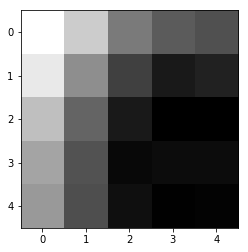

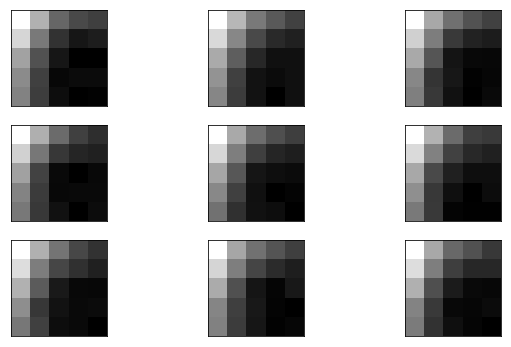

In [9]:
# Данные изображения в ядрах свертки
# получить данные изображения с индексом "0". Для крупного масштаба.
image_y1 = n.weights[0]
# вывод данных изображения участка с индексом "0".
matplotlib.pyplot.imshow(image_y1, cmap='Greys', interpolation='None')

fig = matplotlib.pyplot.figure(figsize=(10,6))
for j in range(9):
    ax = fig.add_subplot(3, 3, j+1)
    ax.imshow(n.weights[j], 
              cmap=matplotlib.cm.binary, interpolation='none')
    matplotlib.pyplot.xticks(np.array([]))
    matplotlib.pyplot.yticks(np.array([]))
matplotlib.pyplot.show()

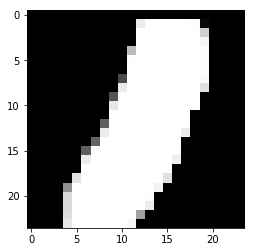

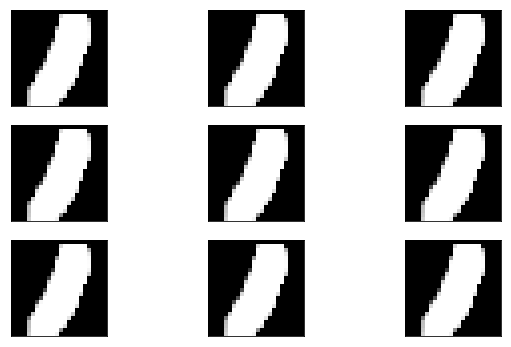

In [10]:
# Данные изображения в признаках(в светочном слое)
# получить данные изображения с индексом "0". Для крупного масштаба. 
image_y1 = n.hidden_outputs_image[0] # Карта запомнила последний тренировочный пример при обучении сети!
# вывод данных изображения участка с индексом "0".
matplotlib.pyplot.imshow(image_y1, cmap='Greys', interpolation='None')

fig = matplotlib.pyplot.figure(figsize=(10,6))
for j in range(9):
    ax = fig.add_subplot(3, 3, j+1)
    ax.imshow(n.hidden_outputs_image[j], 
              cmap=matplotlib.cm.binary, interpolation='none')
    matplotlib.pyplot.xticks(np.array([]))
    matplotlib.pyplot.yticks(np.array([]))
matplotlib.pyplot.show()

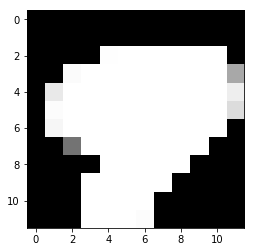

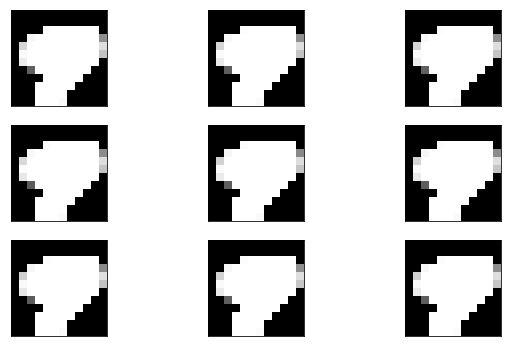

In [11]:
# Данные изображения в признаках(слой макспул)
# получить данные изображения с индексом "0". Для крупного масштаба. 
image_y1 = n.hidden_outputs_mp[0] # Карта запомнила последний тренировочный пример при обучении сети!
# вывод данных изображения участка с индексом "0".
matplotlib.pyplot.imshow(image_y1, cmap='Greys', interpolation='None')

fig = matplotlib.pyplot.figure(figsize=(10,6))
for j in range(9):
    ax = fig.add_subplot(3, 3, j+1)
    ax.imshow(n.hidden_outputs_mp[j], 
              cmap=matplotlib.cm.binary, interpolation='none')
    matplotlib.pyplot.xticks(np.array([]))
    matplotlib.pyplot.yticks(np.array([]))
matplotlib.pyplot.show()